<a href="https://colab.research.google.com/github/keran-w/leaf-classification/blob/main/leaf_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# use github private repo in colab
from google.colab import drive
from IPython.display import clear_output
drive.mount('/content/drive', force_remount=True)

GIT_TOKEN, USERNAME = open('drive/MyDrive/GIT_TOKEN.txt', 'r').read().split('\n')
!git clone https://{GIT_TOKEN}@github.com/{USERNAME}/Toolbox.git
del GIT_TOKEN, USERNAME
clear_output()

In [12]:
from Toolbox.utils import get_dataset_from_kaggle
get_dataset_from_kaggle('classify-leaves')

In [13]:
from Toolbox.utils import pip_install
pip_install('transformers', 'albumentations==0.4.6')

In [14]:
import pandas as pd
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [15]:
from sklearn.preprocessing import LabelEncoder
images, labels = train_df.image.tolist(), train_df.label.tolist()
le = LabelEncoder()
labels = le.fit_transform(labels)
id2label = {v:k for k,v in zip(le.classes_, le.transform(le.classes_))}

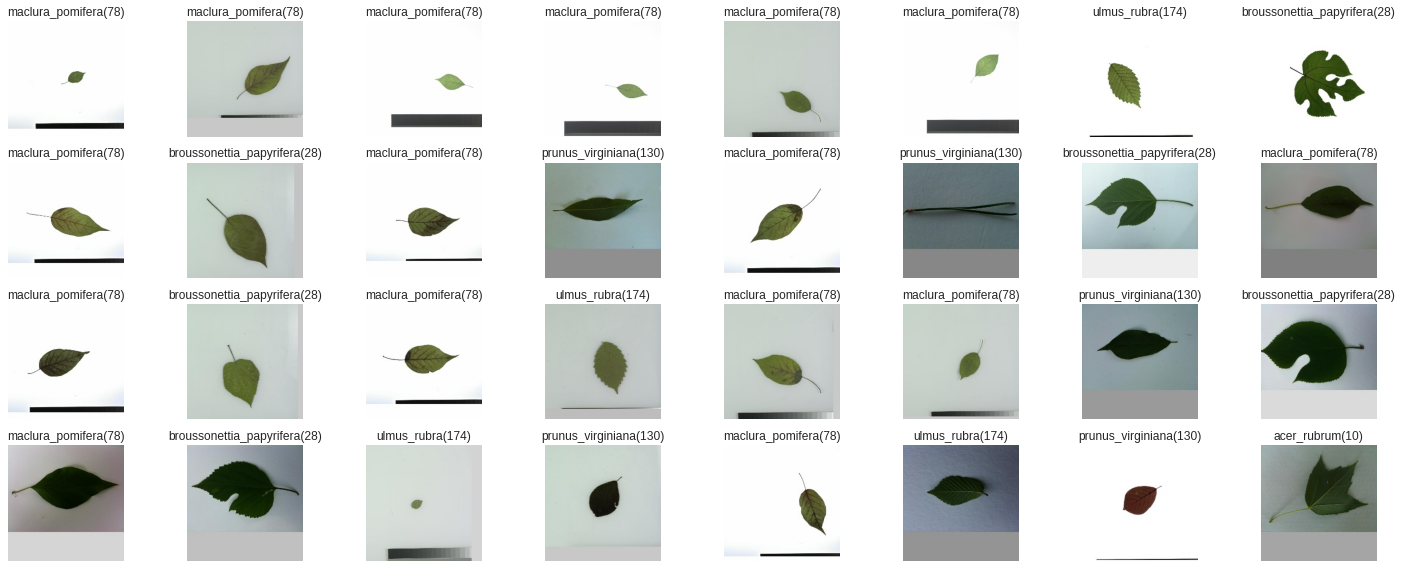

In [16]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

def display_samples(images, labels, label_map=None, count=32, cols=8):
    sample_idx = np.random.choice(len(images), count)
    rows = len(sample_idx) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(20, count // rows))
    
    for i, idx in enumerate(range(count)):
        image, label = images[idx], labels[idx]
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.ravel()[i].imshow(image)
        title = f'{labels[i]}' if label_map is None else f'{label_map[labels[i].item()]}({labels[i]})'
        ax.ravel()[i].set_title(title)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

display_samples(images, labels, id2label)

In [17]:
from transformers import ViTFeatureExtractor, ViTModel
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

In [18]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import torch
import cv2
from sklearn.preprocessing import LabelEncoder

class LeavesDataset(torch.utils.data.Dataset):
    
    def __init__(self, images, labels, mode, feature_extractor, transform=None):
        self.labels = labels
        self.images = images
        self.feature_extractor = feature_extractor
        self.transform = transform
        self.mode = mode
        
    def __len__(self):
        return len(self.images)
         
    def __getitem__(self, index):
        image = Image.open(self.images[index])
        if self.transform is not None:
            image = np.array(image)
            image = Image.fromarray(self.transform(image=image)['image'], 'RGB')
        image = self.feature_extractor(image, return_tensors='pt')['pixel_values'][0]
        item = {'image': image, 'mode':self.mode}
        if self.labels is not None:
            item['label'] = self.labels[index]
        return item

def get_loader(images, labels, mode, transform, feature_extractor, batch_size, shuffle):
    return torch.utils.data.DataLoader(LeavesDataset(images, labels, mode, feature_extractor, transform), batch_size=batch_size, shuffle=shuffle)

In [19]:
# image = Image.open(X_train[0])
# image = np.array(image)
# transform = A.Compose([
#     A.Resize(256, 256),
#     A.RandomCrop(224, 224),
#     A.Flip(p=0.5),
#     A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5)
# ])
# transformed_image_1 = transform(image=image)['image']
# Image.fromarray(transformed_image_1, 'RGB')

In [20]:
from transformers import get_cosine_schedule_with_warmup
from torch import optim, nn
from torch.nn import functional as F

class ArcFace(nn.Module):
    
    def __init__(self,in_features,out_features, margin = 0.5 ,scale = 20):
        super(ArcFace, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.weights = nn.Parameter(torch.FloatTensor(out_features,in_features))
        nn.init.xavier_normal_(self.weights)
        
    def forward(self,features,targets):
        cos_theta = F.linear(F.normalize(features), F.normalize(self.weights), bias=None) 
        cos_theta = cos_theta.clip(-1, 1)
        
        arc_cos = torch.acos(cos_theta)
        M = F.one_hot(targets, num_classes = self.out_features) * self.margin
        arc_cos = arc_cos + M
        
        cos_theta_2 = torch.cos(arc_cos)
        logits = cos_theta_2 * self.scale
        return logits

class Model(torch.nn.Module):
    def __init__(self, vit_model, feature_extractor, num_labels):

        super(Model, self).__init__()
        self.vit = vit_model
        self.feature_extractor = feature_extractor
        self.num_labels = num_labels
        self.arcface = ArcFace(768, num_labels, margin=0.3)
    
    def forward(self, batch, device):
        outputs = self.vit(batch['image'].to(device))
        last_hidden_state = outputs.last_hidden_state[:,0,:]
        if batch['mode'] == 'train':
            return self.arcface(last_hidden_state)
        else:
            return F.linear(F.normalize(last_hidden_state), F.normalize(self.arcface.weights))

class FocalLoss(nn.Module):
    'Focal Loss - https://arxiv.org/abs/1708.02002'
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss()

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

In [21]:
def train_step(model, optimizer, criterion, batch, device):
    optimizer.zero_grad()
    logits = model(batch, device)
    labels = batch['label'].long().to(device)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

def valid_step(model, batch, metrics, device):
    logits = model(batch, device).detach()
    labels = batch['label'].long().to(device)

    result = {}
    for metric in metrics:
        if metric == 'acc':
            result[metric] = (logits.argmax(1) == labels).float().mean()
        # elif metric == ''

    return result

In [22]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
n_epoch = 20
metrics = ['acc']
batch_size = 64
learning_rate = 1e-4
weight_decay = 1e-3
transform = A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(224, 224),
    A.Flip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)
])
device = 'cuda' if torch.cuda.is_available else 'cpu'
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
images = np.array(images)

In [23]:
for k, (train_index, valid_index) in enumerate(skf.split(images, labels)):
    if k in (0, 1, 2): continue
    X_train, y_train, X_valid, y_valid = images[train_index], labels[train_index], images[valid_index], labels[valid_index]
    train_loader = get_loader(X_train, y_train, 'train', transform, feature_extractor, batch_size, False)
    valid_loader = get_loader(X_valid, y_valid, 'valid', None, feature_extractor, batch_size, False)
    vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
    model = Model(vit_model, feature_extractor, len(le.classes_)).to(device)
    criterion = FocalLoss(2)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=int(len(train_loader)*n_epoch*1.2))

    for epoch in range(n_epoch):
        model.train()
        train_pbar = tqdm(train_loader)
        train_pbar.set_description_str(f'k={k}: [ Train {epoch+1:03d}/{n_epoch:03d} ]')
        loss_list, acc_list = [], []
        for batch in train_pbar:
            # loss = train_step(model, optimizer, criterion, batch, device)
            optimizer.zero_grad()
            logits = model(batch, device)
            true_labels = batch['label'].long().to(device)
            loss = criterion(logits, true_labels)
            loss.backward()
            optimizer.step()
            train_pbar.set_postfix_str(f'loss: {loss}')
            loss_list.append(loss.item())
            scheduler.step()

        model.eval()
        with torch.no_grad():
            valid_pbar = tqdm(valid_loader)
            valid_pbar.set_description_str(f'k={k}: [ Valid {epoch+1:03d}/{n_epoch:03d} ]')
            for batch in valid_pbar:
                # results = valid_step(model, batch, metrics, device)
                logits = model(batch, device).detach()
                true_labels = batch['label'].long().to(device)

                results = {}
                for metric in metrics:
                    if metric == 'acc':
                        results[metric] = (logits.argmax(1) == true_labels).float().mean().item()
                valid_pbar.set_postfix_str(f'{" ".join([f"{k}: {v}" for k, v in results.items()])}')
                acc_list.append(results['acc'])

        print(f'Average train loss: {np.mean(loss_list):.4f} Average test accuracy: {np.mean(acc_list):.3f}')
        clear_output()
    torch.save(model, f'drive/MyDrive/saved_models/leaf_cls_model_{k}.pt')

In [24]:
from scipy import stats
preds_list = []
test_loader = get_loader(test_df.image.values, None, 'test', None, feature_extractor, batch_size, False)
for i in range(5):
    model = torch.load(f'drive/MyDrive/saved_models/leaf_cls_model_{i}.pt').to(device)
    model.eval()
    preds = []
    for batch in tqdm(test_loader):
        logits = model(batch, device).detach()
        preds += F.softmax(logits, 1).cpu().tolist()
    preds_list.append(preds)

100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


In [25]:
preds = stats.mode(np.argmax(preds_list, 2).T, 1).mode.squeeze()
submission = pd.read_csv('sample_submission.csv')
submission.label = [id2label[pred] for pred in preds]
submission.to_csv('submission.csv', index=False)

from Toolbox.utils import make_kaggle_submission
make_kaggle_submission('classify-leaves', 'submission.csv')